# Analysis of exploraroty behaviour and resting periods

''' Created on Fri 05 Jun 2020'''


In this notebook we will analyze periods of exploratory behaviour wothout taking into account the object that is being explore. We will take the first 6 seconds of exploration (because we are currently using a re sampling of 20 frames that gives us 2s bins, just to use a multipler), if posible some segment in the middle and the resting periods.

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
import scipy
cmap = cm.jet

In [2]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165           ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 100 ### 100 means everything was aligned, 200 means it was also equalized
alignment_v = 1           ## alignment version
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                 ## value of resampling

session_now = 1 
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        if mouse == 32364:
            fixed = 'LR'
        if mouse == 56165:
            fixed = 'UR'
    else:
        if session_now == 2:
            task = 'STABLE'
        else:
            task = 'RANDOM'
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            
if mouse == 32366:
    sessions = [3,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'

In [3]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_normed/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/figures/exploration_analysis/'

In [4]:
# define all relevant files names
session = session_now
file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{100}' + \
                      '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                      f'{component_evaluation_v}' + '.' + f'{registration_v}' + '.npy'
time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{1}' + \
                      '.' + f'{0}' + '.pkl'
beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '.npy'

In [5]:
##load activity and timeline
activity = np.load(file_directory + file_name_session_1)
timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
timeline_info = pickle.load(timeline_file)
##normalize neural activity
timeline_1 = np.zeros(len(timeline_info) + 1)
for i in range(len(timeline_info)):
    timeline_1[i] = timeline_info[i][1]
timeline_1[len(timeline_info)] = activity.shape[1]
neural_activity1 = activity[1:,:]
##downsample neural activity
resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity1,
                                                                                    re_sf=re_sf)
## LOAD BEHAVIOUR
behaviour = np.load(behaviour_dir + beh_file_name_1)
#c = np.linspace(0, 20, len(behaviour))
reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
resample_timeline = timeline_1/re_sf

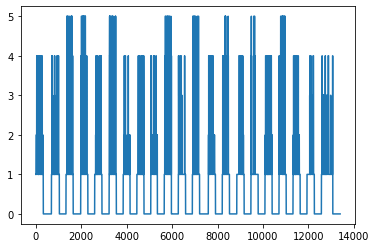

In [6]:
plt.plot(resample_beh1)

In [7]:
events_list = []
events_counter_list = []
events_time_starts = []
start_counter = 100
counter = 0
for i in range(resample_beh1.shape[0]):
    if resample_beh1[i] != start_counter:
        events_list.append(start_counter)
        events_counter_list.append(counter)
        events_time_starts.append(i)
        start_counter = resample_beh1[i]
        counter = 1
    else:
        counter = counter + 1

In [103]:
period = 20
events = np.array(events_list)
events_counter = np.array(events_counter_list)
events_time = np.array(events_time_starts)

resting_activity = []
target = 0
position_events = np.where(events == target)[0]
events_duration = events_counter[position_events]   # convert to seconds
i = 0
for event in events_duration:
    if event > period:
        resting_activity.append(resample_neural_activity_mean[:,events_time[i]:events_time[i]+period])
    i = i + 1

nonexploring_activity = []
target = 1
position_events = np.where(events == target)[0]
events_duration = events_counter[position_events]
i = 0
for event in events_duration:
    if event > period:
        nonexploring_activity.append(resample_neural_activity_mean[:,events_time[i]:events_time[i]+period])
    i = i+1
    
exploring_activity = []
for target in [2,3,4,5]:
    position_events = np.where(events == target)[0]
    events_duration = events_counter[position_events]
    i = 0
    for event in events_duration:
        if event > period:
            exploring_activity.append(resample_neural_activity_mean[:,events_time[i]:events_time[i]+period])
    i = i+1

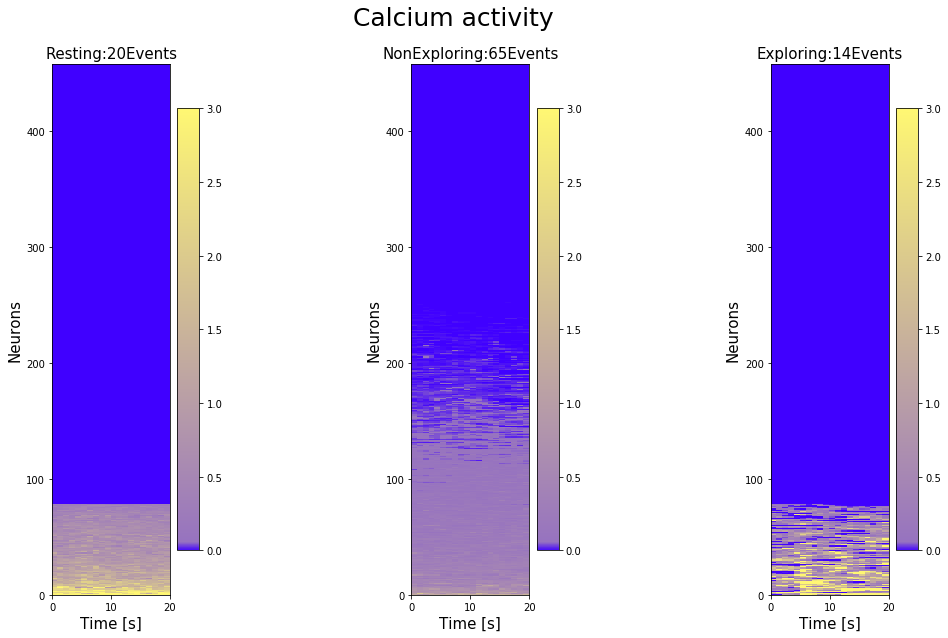

In [104]:

mean_over_trials = np.mean(resting_activity, axis= 0)
mean_firing_rate = np.mean(mean_over_trials, axis = 1)
positions = np.flip(np.argsort(mean_firing_rate))
resting = mean_over_trials[positions,:]

mean_over_trials = np.mean(nonexploring_activity, axis= 0)
mean_firing_rate = np.mean(mean_over_trials, axis = 1)
positions = np.flip(np.argsort(mean_firing_rate))
nonexploring = mean_over_trials[positions,:]

mean_over_trials = np.mean(exploring_activity, axis= 0)
mean_firing_rate = np.mean(mean_over_trials, axis = 1)
positions = np.flip(np.argsort(mean_firing_rate))
exploring = mean_over_trials[positions,:]

import matplotlib as m

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}
cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)


vmin= 0
vmax=3
fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_title('Resting:'+ f'{len(resting_activity)}' + 'Events' , fontsize = 15)
ax.set_ylabel('Neurons', fontsize = 15)
ax.set_xlabel('Time [s]', fontsize = 15)
mesh = ax.pcolormesh(resting, cmap = cm)
mesh.set_clim(vmin,vmax)

ax1 = fig.add_subplot(132)
ax1.set_title('NonExploring:'+ f'{len(nonexploring_activity)}' + 'Events' , fontsize = 15)
ax1.set_ylabel('Neurons', fontsize = 15)
ax1.set_xlabel('Time [s]', fontsize = 15)
mesh1 = ax1.pcolormesh(nonexploring, cmap = cm)
mesh1.set_clim(vmin,vmax)

ax2 = fig.add_subplot(133)
ax2.set_title('Exploring:'+ f'{len(exploring_activity)}' + 'Events'  , fontsize = 15)
ax2.set_ylabel('Neurons', fontsize = 15)
ax2.set_xlabel('Time [s]', fontsize = 15)
mesh2 = ax2.pcolormesh(exploring, cmap = cm)
mesh2.set_clim(vmin,vmax)
# Visualizing colorbar part -start
fig.colorbar(mesh,ax=ax)
fig.colorbar(mesh1,ax=ax1)
fig.colorbar(mesh2,ax=ax2)
fig.tight_layout()
fig.set_size_inches(15,10)
fig.suptitle('Calcium activity', fontsize = 25)

figure_name = figure_path +'calcium_activity_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)


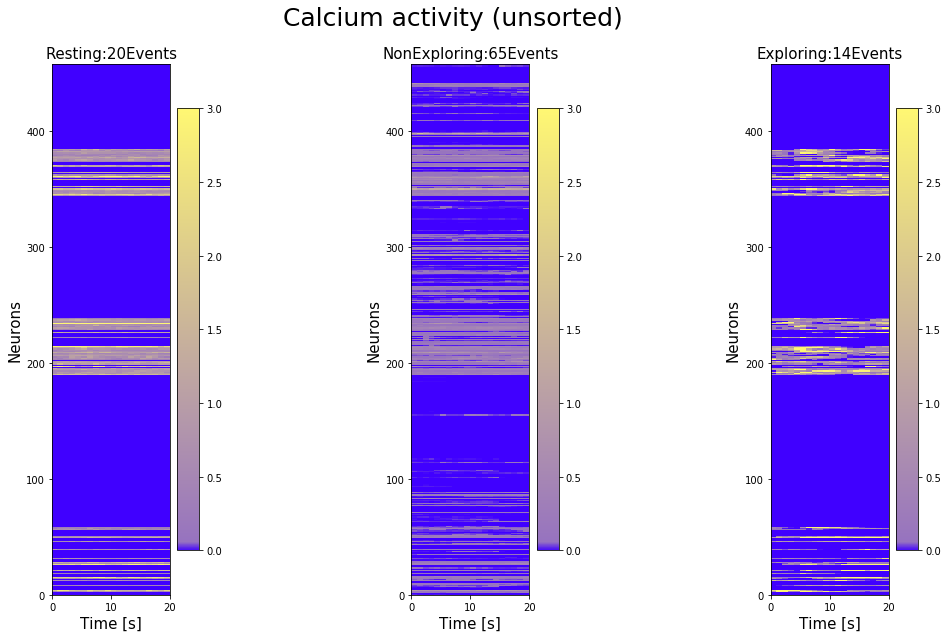

In [105]:

mean_over_trials = np.mean(resting_activity, axis= 0)
resting = mean_over_trials

mean_over_trials = np.mean(nonexploring_activity, axis= 0)
nonexploring = mean_over_trials

mean_over_trials = np.mean(exploring_activity, axis= 0)
exploring = mean_over_trials

import matplotlib as m

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}
cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)


vmin= 0
vmax=3
fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_title('Resting:'+ f'{len(resting_activity)}' + 'Events' , fontsize = 15)
ax.set_ylabel('Neurons', fontsize = 15)
ax.set_xlabel('Time [s]', fontsize = 15)
mesh = ax.pcolormesh(resting, cmap = cm)
mesh.set_clim(vmin,vmax)

ax1 = fig.add_subplot(132)
ax1.set_title('NonExploring:'+ f'{len(nonexploring_activity)}' + 'Events' , fontsize = 15)
ax1.set_ylabel('Neurons', fontsize = 15)
ax1.set_xlabel('Time [s]', fontsize = 15)
mesh1 = ax1.pcolormesh(nonexploring, cmap = cm)
mesh1.set_clim(vmin,vmax)

ax2 = fig.add_subplot(133)
ax2.set_title('Exploring:'+ f'{len(exploring_activity)}' + 'Events'  , fontsize = 15)
ax2.set_ylabel('Neurons', fontsize = 15)
ax2.set_xlabel('Time [s]', fontsize = 15)
mesh2 = ax2.pcolormesh(exploring, cmap = cm)
mesh2.set_clim(vmin,vmax)
# Visualizing colorbar part -start
fig.colorbar(mesh,ax=ax)
fig.colorbar(mesh1,ax=ax1)
fig.colorbar(mesh2,ax=ax2)
fig.tight_layout()
fig.set_size_inches(15,10)
fig.suptitle('Calcium activity (unsorted)', fontsize = 25)

figure_name = figure_path +'calcium_activity_unsorted_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)
